## Flow Model

Any generative model especially in the image space are considered as transport problem. U will start from one distribution (usually random or uniform) and move to another distribution (data distribution). The reason for doing this is that we don't know data distribution and only have i.i.d samples (aka data), also the data distribution is often complex and difficult to sample from. SDE, DDPM, Normalizing flows, continous flows, GANs and VAEs are some of these approaches. 

while training any generative models, we would like to have some nice properties. 
- Generate high quality images/videos. 
- Optimal cost of inference. 
- Deterministic. 

To our advantage, there is one paper which explains us how to do this [Flow Straight and Fast: Learning to Generate and Transfer Data with Rectified Flow](https://arxiv.org/pdf/2209.03003)

## Pre-requsites
- Ordinary Differential equations
- ODE solvers.


Flow is designed as an optimal transport problem. we transport images from one distribution $\pi_{0}$ (noise) to another distribution $\pi_{1}$ (data distribution). the following are the set of equations defined in the paper.

$$
x_{t} = tx_{1}+(1-t)x_{0} \tag{1}
$$

$$
\frac{dx_{t}}{dt} = x_{1} - x_{0} \tag{2}
$$

the goal of the neural network is to learn the above differential equation. we sample t and find x_{t} using eq(1) and then we will pass x_{t} and t to the neural network T(x_t, t) and get an output. 

the optimization problem is to solve 

$$
\int_{0}^{t} ||(x_{1} - x_{0}) - (T(x_{t}, t))||^{2}_{2} \tag{2}
$$

How do we sample t? we know that t should be between 0-1, so we can use any distribution which samples and produces numbers within this range. so we can use simple uniform distribution or logit normal distribution (this is from another paper, which experimented with different distribution and found this to work better). we will discuss more about this later

## Psuedo algorithm while training
- take a batch of images $x_{1}$
- sample noise $x_{0}$
- sample a t for each image. use $x_{1}$, $x_{0}$ and $t$ to produce $x_{t}$
- use neural network T($x_{t}$, t) to process the inputs.
- calculate mean squared error as given in eq(3)
- repeat the process.

this is it, the model is trained and evaluated in the entire ambient space. think of Neural network is in y axis and t is in x axis, we know the gradient (direction) at each and every point. 

## Inference.
since we know the starting point ($x_{0}$), and direction is given by the neural network at the point, we can use euler's method to transport this noise and generate an image. 

$$
x_{t} = x_{t-1}+ \nabla_{t} f(x_{t-1}, t-1) 
$$

if we use t = 0.1 as step size, then we find the images as $x_{0.1}$, $x_{0.2}$, $x_{0.3}$, ... $x_{1}$. this took 10 evaluation steps. if we use a step size of 0.01, we use 100 steps.

we can also use advanced numerical solvers like  RK2 .. RK5 to solve the ODE and generate new samples. we will see with code below on how to do this. 


Fundamentally this is what flow means. Simple and Clean

## Some interesting properties mentioned in the paper
- Flow path don't cross each other (aka non-crossing property). In the ambient space, if u take any point we get only one gradient, if a crossing is present, at that point, we need to have two different values for $dx_{t}/dt$ which is not possible in ODE setting. so if you sample 10 points from $\pi_{0}$ traverse the path to $\pi_{1}$ u will see that none of them meet at any point. 
- the probability is preserved throughout the flow. Law($X_{t}$) = Law($Z_{t}$). Here $z_{t}$ is model output and $X_{t}$ is obtained using linear equation described here
- Reducing transport costs. the cost of transporting $z_{0}$ to $z_{1}$ is always lower than cost of transporting $x_{0}$ to $x_{1}$ no matter whatever cost function u use. this allows us to not worry about the cost function.
- Reflow, straightening and fast simulation. if we train a new model on $z_{0}$ to $z_{1}$ then it is called reflow-1, if we again train on reflow-1 outputs, it is called reflow-2. As more reflow's occur the paths become more straight which allows to simulate fast during inference. 
- when doing image to image translation, it is better to add a small noise to inputs as this will lead to a smooth input variable. 

In [1]:
# Looad required libraries 

import torch 
import numpy as np
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

In [2]:
# Now say we have MNIST data in the shape of (N, 1, 28, 28)
# we will create a VAE model to generate new images similar to the training data. 

# Load MNIST data 

# Load MNIST data and resize it to 64x64
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Pad(2),
                                    torchvision.transforms.ToTensor(),
                                ])),
    batch_size=128, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Pad(2),
                                    torchvision.transforms.ToTensor(),
                                ])),
    batch_size=128, shuffle=False)

len(train_loader), len(val_loader)

(469, 79)

In [3]:
imgs, labels = next(iter(train_loader))
imgs.shape, labels.shape

(torch.Size([128, 1, 32, 32]), torch.Size([128]))

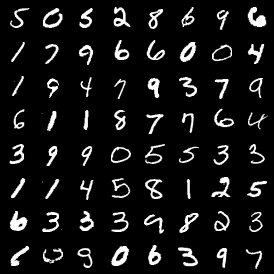

In [4]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(imgs[:64], nrow=8, normalize=False))

# first lets train using linear flow 

In [5]:
time = torch.distributions.Uniform(0, 1)
time.sample((10,))

tensor([0.1826, 0.8870, 0.2690, 0.7950, 0.7292, 0.3459, 0.3261, 0.1975, 0.8006,
        0.7232])

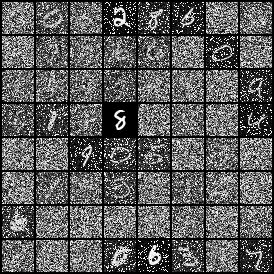

In [6]:
# eq = xt = tx1 + (1-t)x0 where x0 is pure noise and x1 is the original name 
bs = imgs.shape[0]
t = time.sample((bs,)).unsqueeze(1).unsqueeze(1).unsqueeze(1)
noise = torch.randn_like(imgs)
xt = t*(2*imgs-1) + (1-t)*noise
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid((xt[:64]+1)/2, nrow=8, normalize=False))

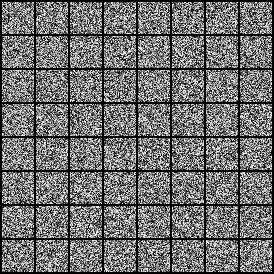

In [7]:
target = (2*imgs-1) - noise
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(target[:64], nrow=8, normalize=False))

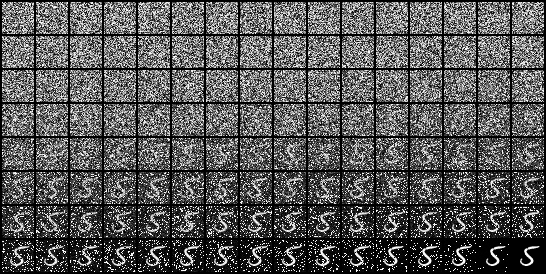

In [8]:
# lets also look how same image looks at different timesteps
simgs = imgs[0].unsqueeze(0).repeat(128, 1, 1, 1)
bs = simgs.shape[0]
t = torch.linspace(0, 1, bs).unsqueeze(1).unsqueeze(1).unsqueeze(1)
noise = torch.randn_like(simgs)
sxt = (t)*(2*simgs-1) + (1-t)*noise
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid((sxt+1)/2, nrow=16, normalize=False))

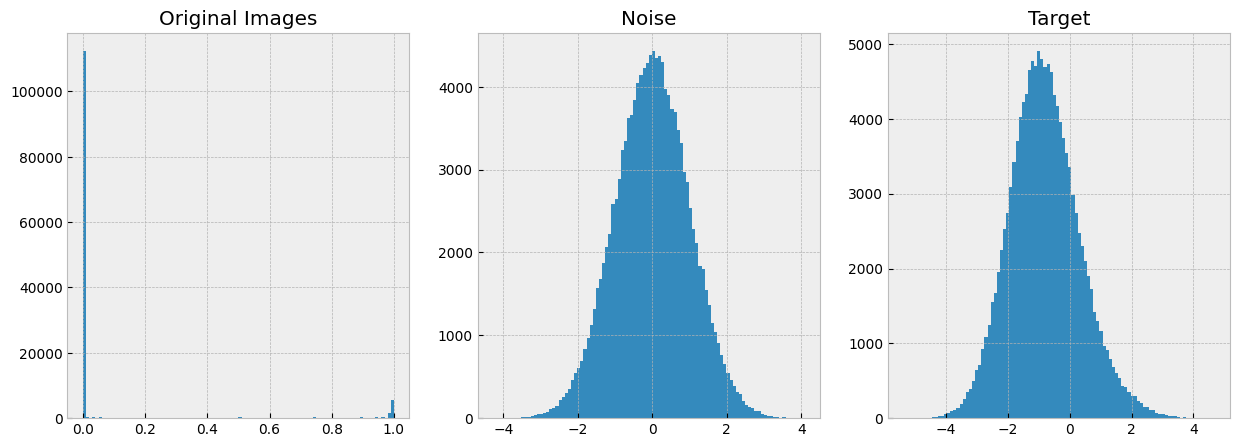

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(imgs.view(-1).numpy(), bins=100)
ax[0].set_title('Original Images')
ax[1].hist(noise.view(-1).numpy(), bins=100)
ax[1].set_title('Noise')
ax[2].hist(target.view(-1).numpy(), bins=100)
ax[2].set_title('Target')
plt.show()

## network

In [10]:
from diffusers import UNet2DModel

device = "cuda"

model = UNet2DModel(
    sample_size=32,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(128, 256, 256, 256),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
)
model.to(device)
print("model loaded")

/home/prakashjay/genai/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


model loaded


In [11]:
count = 0
for name, param in model.named_parameters():
    count += param.numel()
count # this is a ~16 million parameters model


35741697

In [12]:
out = model(xt.to(device), t.flatten(0).to(device))
out.sample.shape, torch.nn.functional.mse_loss(out.sample, target.to(device))

(torch.Size([128, 1, 32, 32]),
 tensor(2.2701, device='cuda:0', grad_fn=<MseLossBackward0>))

In [13]:
def sample_images(model, n_samples, device):
    model.eval()
    time_steps = torch.linspace(0, 1, 50).to(device)
    final_images = torch.zeros(n_samples, 50, 1, 32, 32, device=device)
    noise = torch.randn((n_samples, 1, 32, 32), device=device)
    for i, t in tqdm(enumerate(time_steps)):
        #x_{t} = x_{t-1}+f(x_{t-1}, t-1) 
        if i == 0:
            xt = noise 
            final_images[:, i, ...] = noise 
        else:
            dt = time_steps[i] - time_steps[i-1]
            with torch.no_grad():
                xt = final_images[:, i-1, ...] + dt * model(final_images[:, i-1, ...], time_steps[i-1].repeat(n_samples))["sample"]
        final_images[:, i, ...] = xt.detach()
        #print(f"sampled {i} images")
    return final_images

In [14]:
final_images = sample_images(model, 32, device)

14it [00:00, 69.69it/s]

50it [00:00, 74.60it/s]


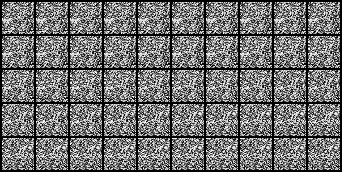

In [15]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid((final_images[0]+1)/2, nrow=10, normalize=False))

> train the model 

In [16]:
# we will add EMA weights to the model. 
import copy

def exists(val):
    return val is not None

class EMA():
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
    def update_average(self, old, new):
        if not exists(old):
            return new
        return old * self.beta + (1 - self.beta) * new

ema = EMA(beta=0.9999)
ema_model = copy.deepcopy(model)

In [17]:
epochs = 100 
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-5)
total_steps = len(train_loader) * epochs
tdist = torch.distributions.Uniform(0, 1)

iter = 0 
train_loss = []

for epoch in range(epochs):
    model.train()
    epoch_loss = []
    with tqdm(train_loader, unit="batch") as tepoch:
        for batch in tepoch:
            optimizer.zero_grad()
            
            x1, _ = batch
            x1 = 2*x1.to(device) - 1
            noise = torch.randn((x1.shape[0], 1, 32, 32), device=device)
            t = tdist.sample((x1.shape[0],)).unsqueeze(1).unsqueeze(1).unsqueeze(1).to(device)
            xt = t*x1 + (1-t)*noise
            target = x1 - noise 
            model_output = model(xt.to(device), t.flatten(0).to(device))["sample"]
            
            loss = torch.nn.functional.mse_loss(model_output, target.to(device))
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Add gradient clipping
            optimizer.step()

            #calculate loss 
            tepoch.set_postfix(loss=loss.item())
            epoch_loss.append(loss.item())
                    
            #update ema model 
            for current_params, ma_params in zip(model.parameters(), ema_model.parameters()):
                    old_weight, up_weight = ma_params.data, current_params.data
                    ma_params.data = ema.update_average(old_weight, up_weight)
    
    train_loss.extend(epoch_loss)
    store = {
         "ema_model": ema_model.state_dict(),
         "model": model.state_dict(),
         "train_loss": np.mean(epoch_loss)
    }
    torch.save(store, f"generated/ema_model_{epoch}_{np.mean(epoch_loss):3f}.pth")
    print(f"Epoch {epoch} completed: train loss {np.mean(epoch_loss)}")
    #TODO: calculate some metric between generated images and original images

    ema_model.eval()
    out= sample_images(ema_model, 4, device)
    out = (out+1)/2
    img = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(out[0].cpu(), nrow=10, normalize=True))
    img.save(f"generated/generated_images_{epoch}.png")
        

100%|██████████| 469/469 [00:31<00:00, 14.73batch/s, loss=0.151]


Epoch 0 completed: train loss 0.19402835100317306


50it [00:00, 75.81it/s]
100%|██████████| 469/469 [00:31<00:00, 14.92batch/s, loss=0.144]


Epoch 1 completed: train loss 0.14940462628407264


50it [00:00, 81.78it/s]
100%|██████████| 469/469 [00:31<00:00, 14.97batch/s, loss=0.133]


Epoch 2 completed: train loss 0.14326804326668477


50it [00:00, 80.95it/s]
100%|██████████| 469/469 [00:31<00:00, 14.93batch/s, loss=0.138]


Epoch 3 completed: train loss 0.1402587376074242


50it [00:00, 80.89it/s]
100%|██████████| 469/469 [00:31<00:00, 14.93batch/s, loss=0.13] 


Epoch 4 completed: train loss 0.13859565905543533


50it [00:00, 82.21it/s]
100%|██████████| 469/469 [00:31<00:00, 14.93batch/s, loss=0.147]


Epoch 5 completed: train loss 0.13732517718760442


50it [00:00, 81.07it/s]
100%|██████████| 469/469 [00:31<00:00, 14.93batch/s, loss=0.133]


Epoch 6 completed: train loss 0.13664828529998438


50it [00:00, 80.55it/s]
100%|██████████| 469/469 [00:31<00:00, 14.97batch/s, loss=0.133]


Epoch 7 completed: train loss 0.13506495860466824


50it [00:00, 82.12it/s]
100%|██████████| 469/469 [00:31<00:00, 14.92batch/s, loss=0.124]


Epoch 8 completed: train loss 0.13460511255111776


50it [00:00, 80.69it/s]
100%|██████████| 469/469 [00:31<00:00, 14.97batch/s, loss=0.136]


Epoch 9 completed: train loss 0.1341421803844763


50it [00:00, 81.74it/s]
100%|██████████| 469/469 [00:31<00:00, 14.92batch/s, loss=0.128]


Epoch 10 completed: train loss 0.13373837278468775


50it [00:00, 82.51it/s]
100%|██████████| 469/469 [00:31<00:00, 14.96batch/s, loss=0.129]


Epoch 11 completed: train loss 0.1336841565777244


50it [00:00, 80.52it/s]
100%|██████████| 469/469 [00:31<00:00, 14.96batch/s, loss=0.136]


Epoch 12 completed: train loss 0.13235613319284117


50it [00:00, 80.78it/s]
100%|██████████| 469/469 [00:31<00:00, 14.99batch/s, loss=0.131]


Epoch 13 completed: train loss 0.13221365446919825


50it [00:00, 82.16it/s]
100%|██████████| 469/469 [00:31<00:00, 14.98batch/s, loss=0.123]


Epoch 14 completed: train loss 0.13144238301113978


50it [00:00, 81.81it/s]
100%|██████████| 469/469 [00:31<00:00, 14.98batch/s, loss=0.133]


Epoch 15 completed: train loss 0.1313788206942046


50it [00:00, 80.90it/s]
100%|██████████| 469/469 [00:31<00:00, 14.99batch/s, loss=0.135]


Epoch 16 completed: train loss 0.13158913096512304


50it [00:00, 81.63it/s]
100%|██████████| 469/469 [00:31<00:00, 15.00batch/s, loss=0.127]


Epoch 17 completed: train loss 0.13107531037983863


50it [00:00, 81.46it/s]
100%|██████████| 469/469 [00:31<00:00, 15.00batch/s, loss=0.127]


Epoch 18 completed: train loss 0.13111712154485525


50it [00:00, 81.85it/s]
100%|██████████| 469/469 [00:31<00:00, 14.99batch/s, loss=0.131]


Epoch 19 completed: train loss 0.13077872881947805


50it [00:00, 82.51it/s]
100%|██████████| 469/469 [00:31<00:00, 14.87batch/s, loss=0.133]


Epoch 20 completed: train loss 0.13008542369995543


50it [00:00, 81.07it/s]
100%|██████████| 469/469 [00:31<00:00, 14.92batch/s, loss=0.136]


Epoch 21 completed: train loss 0.13055444295917237


50it [00:00, 80.69it/s]
100%|██████████| 469/469 [00:31<00:00, 14.90batch/s, loss=0.138]


Epoch 22 completed: train loss 0.13029297900352396


50it [00:00, 81.34it/s]
100%|██████████| 469/469 [00:31<00:00, 14.91batch/s, loss=0.139]


Epoch 23 completed: train loss 0.12945680599858259


50it [00:00, 81.30it/s]
100%|██████████| 469/469 [00:31<00:00, 14.92batch/s, loss=0.12] 


Epoch 24 completed: train loss 0.1298628507583126


50it [00:00, 81.12it/s]
100%|██████████| 469/469 [00:31<00:00, 14.91batch/s, loss=0.125]


Epoch 25 completed: train loss 0.12948763378456965


50it [00:00, 81.63it/s]
100%|██████████| 469/469 [00:31<00:00, 14.95batch/s, loss=0.123]


Epoch 26 completed: train loss 0.1297421257124781


50it [00:00, 81.76it/s]
100%|██████████| 469/469 [00:31<00:00, 14.99batch/s, loss=0.122]


Epoch 27 completed: train loss 0.12918762073143206


50it [00:00, 81.20it/s]
100%|██████████| 469/469 [00:31<00:00, 14.98batch/s, loss=0.125]


Epoch 28 completed: train loss 0.12924627775449488


50it [00:00, 82.28it/s]
100%|██████████| 469/469 [00:31<00:00, 14.97batch/s, loss=0.12] 


Epoch 29 completed: train loss 0.12963274288088528


50it [00:00, 81.23it/s]
100%|██████████| 469/469 [00:31<00:00, 14.99batch/s, loss=0.131]


Epoch 30 completed: train loss 0.12920973632635593


50it [00:00, 81.13it/s]
100%|██████████| 469/469 [00:31<00:00, 14.98batch/s, loss=0.124]


Epoch 31 completed: train loss 0.12891400284540933


50it [00:00, 82.81it/s]
100%|██████████| 469/469 [00:31<00:00, 15.01batch/s, loss=0.124]


Epoch 32 completed: train loss 0.12873554089938655


50it [00:00, 81.91it/s]
100%|██████████| 469/469 [00:31<00:00, 14.99batch/s, loss=0.148]


Epoch 33 completed: train loss 0.12879453497781937


50it [00:00, 81.95it/s]
100%|██████████| 469/469 [00:31<00:00, 14.99batch/s, loss=0.128]


Epoch 34 completed: train loss 0.1287042962462663


50it [00:00, 82.13it/s]
100%|██████████| 469/469 [00:31<00:00, 15.03batch/s, loss=0.13] 


Epoch 35 completed: train loss 0.12846585526776466


50it [00:00, 81.82it/s]
100%|██████████| 469/469 [00:31<00:00, 14.97batch/s, loss=0.122]


Epoch 36 completed: train loss 0.12900992166767242


50it [00:00, 81.15it/s]
100%|██████████| 469/469 [00:31<00:00, 14.93batch/s, loss=0.125]


Epoch 37 completed: train loss 0.12857506103289407


50it [00:00, 81.60it/s]
100%|██████████| 469/469 [00:31<00:00, 14.97batch/s, loss=0.135]


Epoch 38 completed: train loss 0.12813386306770322


50it [00:00, 81.46it/s]
100%|██████████| 469/469 [00:31<00:00, 14.98batch/s, loss=0.138]


Epoch 39 completed: train loss 0.12782911125467275


50it [00:00, 80.96it/s]
100%|██████████| 469/469 [00:31<00:00, 14.98batch/s, loss=0.127]


Epoch 40 completed: train loss 0.128244809822233


50it [00:00, 82.37it/s]
100%|██████████| 469/469 [00:31<00:00, 15.00batch/s, loss=0.12] 


Epoch 41 completed: train loss 0.12734222413697985


50it [00:00, 81.27it/s]
100%|██████████| 469/469 [00:31<00:00, 14.96batch/s, loss=0.128]


Epoch 42 completed: train loss 0.1281300671001487


50it [00:00, 81.54it/s]
100%|██████████| 469/469 [00:31<00:00, 14.99batch/s, loss=0.127] 


Epoch 43 completed: train loss 0.1280935496282476


50it [00:00, 82.44it/s]
100%|██████████| 469/469 [00:31<00:00, 15.00batch/s, loss=0.125]


Epoch 44 completed: train loss 0.12759938701065873


50it [00:00, 81.38it/s]
100%|██████████| 469/469 [00:31<00:00, 14.98batch/s, loss=0.108]


Epoch 45 completed: train loss 0.12786643202307382


50it [00:00, 81.39it/s]
100%|██████████| 469/469 [00:31<00:00, 14.93batch/s, loss=0.122]


Epoch 46 completed: train loss 0.12740261079088203


50it [00:00, 81.82it/s]
100%|██████████| 469/469 [00:31<00:00, 15.02batch/s, loss=0.131]


Epoch 47 completed: train loss 0.1276342338526935


50it [00:00, 81.42it/s]
100%|██████████| 469/469 [00:31<00:00, 14.97batch/s, loss=0.122]


Epoch 48 completed: train loss 0.12788705694586483


50it [00:00, 80.99it/s]
100%|██████████| 469/469 [00:31<00:00, 14.98batch/s, loss=0.131]


Epoch 49 completed: train loss 0.12804170721756625


50it [00:00, 82.12it/s]
100%|██████████| 469/469 [00:31<00:00, 15.00batch/s, loss=0.121]


Epoch 50 completed: train loss 0.12778557875136068


50it [00:00, 81.58it/s]
100%|██████████| 469/469 [00:31<00:00, 14.99batch/s, loss=0.11] 


Epoch 51 completed: train loss 0.1279300905144545


50it [00:00, 81.18it/s]
100%|██████████| 469/469 [00:31<00:00, 14.92batch/s, loss=0.126]


Epoch 52 completed: train loss 0.127284401118247


50it [00:00, 81.69it/s]
100%|██████████| 469/469 [00:31<00:00, 15.01batch/s, loss=0.131]


Epoch 53 completed: train loss 0.1279987539373227


50it [00:00, 81.93it/s]
100%|██████████| 469/469 [00:31<00:00, 15.00batch/s, loss=0.127]


Epoch 54 completed: train loss 0.1278447454004908


50it [00:00, 81.74it/s]
100%|██████████| 469/469 [00:31<00:00, 14.96batch/s, loss=0.129]


Epoch 55 completed: train loss 0.12713616802049343


50it [00:00, 82.29it/s]
100%|██████████| 469/469 [00:31<00:00, 15.01batch/s, loss=0.13] 


Epoch 56 completed: train loss 0.12738184402110989


50it [00:00, 81.83it/s]
100%|██████████| 469/469 [00:31<00:00, 14.98batch/s, loss=0.117]


Epoch 57 completed: train loss 0.12737526595274776


50it [00:00, 81.04it/s]
100%|██████████| 469/469 [00:31<00:00, 14.94batch/s, loss=0.13] 


Epoch 58 completed: train loss 0.12709815450695786


50it [00:00, 82.18it/s]
100%|██████████| 469/469 [00:31<00:00, 15.02batch/s, loss=0.123]


Epoch 59 completed: train loss 0.12678713345133674


50it [00:00, 81.58it/s]
100%|██████████| 469/469 [00:31<00:00, 14.99batch/s, loss=0.118]


Epoch 60 completed: train loss 0.12787163516542296


50it [00:00, 81.38it/s]
100%|██████████| 469/469 [00:31<00:00, 14.98batch/s, loss=0.122]


Epoch 61 completed: train loss 0.12684550833727506


50it [00:00, 81.79it/s]
100%|██████████| 469/469 [00:31<00:00, 15.01batch/s, loss=0.123]


Epoch 62 completed: train loss 0.1280141849158161


50it [00:00, 81.27it/s]
100%|██████████| 469/469 [00:31<00:00, 15.01batch/s, loss=0.122]


Epoch 63 completed: train loss 0.1270726976523013


50it [00:00, 80.89it/s]
100%|██████████| 469/469 [00:31<00:00, 14.94batch/s, loss=0.124]


Epoch 64 completed: train loss 0.12666749904976723


50it [00:00, 82.09it/s]
100%|██████████| 469/469 [00:31<00:00, 15.00batch/s, loss=0.128]


Epoch 65 completed: train loss 0.12651717416576738


50it [00:00, 81.45it/s]
100%|██████████| 469/469 [00:31<00:00, 14.96batch/s, loss=0.124]


Epoch 66 completed: train loss 0.12720093226381965


50it [00:00, 80.73it/s]
100%|██████████| 469/469 [00:31<00:00, 14.95batch/s, loss=0.119]


Epoch 67 completed: train loss 0.12706834444803977


50it [00:00, 81.60it/s]
100%|██████████| 469/469 [00:31<00:00, 14.99batch/s, loss=0.14] 


Epoch 68 completed: train loss 0.1265808598382641


50it [00:00, 82.63it/s]
100%|██████████| 469/469 [00:31<00:00, 14.94batch/s, loss=0.131]


Epoch 69 completed: train loss 0.12715222368807172


50it [00:00, 81.43it/s]
100%|██████████| 469/469 [00:31<00:00, 14.94batch/s, loss=0.125]


Epoch 70 completed: train loss 0.1269351795061565


50it [00:00, 82.28it/s]
100%|██████████| 469/469 [00:31<00:00, 14.94batch/s, loss=0.121]


Epoch 71 completed: train loss 0.12701629067280654


50it [00:00, 82.13it/s]
100%|██████████| 469/469 [00:31<00:00, 14.96batch/s, loss=0.123]


Epoch 72 completed: train loss 0.12640289398335192


50it [00:00, 81.93it/s]
100%|██████████| 469/469 [00:31<00:00, 14.95batch/s, loss=0.137]


Epoch 73 completed: train loss 0.12685814145595026


50it [00:00, 82.68it/s]
100%|██████████| 469/469 [00:31<00:00, 14.94batch/s, loss=0.123]


Epoch 74 completed: train loss 0.12675481850404474


50it [00:00, 81.38it/s]
100%|██████████| 469/469 [00:31<00:00, 14.98batch/s, loss=0.133]


Epoch 75 completed: train loss 0.12696203327318753


50it [00:00, 81.27it/s]
100%|██████████| 469/469 [00:31<00:00, 14.95batch/s, loss=0.13] 


Epoch 76 completed: train loss 0.1264467402530123


50it [00:00, 82.19it/s]
100%|██████████| 469/469 [00:31<00:00, 14.98batch/s, loss=0.134]


Epoch 77 completed: train loss 0.1264721300683296


50it [00:00, 81.72it/s]
100%|██████████| 469/469 [00:31<00:00, 14.98batch/s, loss=0.126]


Epoch 78 completed: train loss 0.1260702023024498


50it [00:00, 81.90it/s]
100%|██████████| 469/469 [00:31<00:00, 14.93batch/s, loss=0.137]


Epoch 79 completed: train loss 0.12674593496551392


50it [00:00, 82.32it/s]
100%|██████████| 469/469 [00:31<00:00, 14.97batch/s, loss=0.128]


Epoch 80 completed: train loss 0.12613903907443413


50it [00:00, 80.96it/s]
100%|██████████| 469/469 [00:31<00:00, 14.95batch/s, loss=0.132]


Epoch 81 completed: train loss 0.12642816922812064


50it [00:00, 81.83it/s]
100%|██████████| 469/469 [00:31<00:00, 14.92batch/s, loss=0.15] 


Epoch 82 completed: train loss 0.1266055014818462


50it [00:00, 82.26it/s]
100%|██████████| 469/469 [00:31<00:00, 14.97batch/s, loss=0.119]


Epoch 83 completed: train loss 0.1262285135734056


50it [00:00, 81.40it/s]
100%|██████████| 469/469 [00:31<00:00, 14.98batch/s, loss=0.12] 


Epoch 84 completed: train loss 0.12627043389181083


50it [00:00, 81.50it/s]
100%|██████████| 469/469 [00:31<00:00, 14.97batch/s, loss=0.118]


Epoch 85 completed: train loss 0.12558871309068412


50it [00:00, 83.18it/s]
100%|██████████| 469/469 [00:31<00:00, 14.99batch/s, loss=0.127]


Epoch 86 completed: train loss 0.12676542647866043


50it [00:00, 81.30it/s]
100%|██████████| 469/469 [00:31<00:00, 14.98batch/s, loss=0.141]


Epoch 87 completed: train loss 0.12654780648918804


50it [00:00, 81.52it/s]
100%|██████████| 469/469 [00:31<00:00, 14.95batch/s, loss=0.129]


Epoch 88 completed: train loss 0.126142083597717


50it [00:00, 82.14it/s]
100%|██████████| 469/469 [00:31<00:00, 14.99batch/s, loss=0.121]


Epoch 89 completed: train loss 0.12618985000068444


50it [00:00, 81.90it/s]
100%|██████████| 469/469 [00:31<00:00, 14.95batch/s, loss=0.111]


Epoch 90 completed: train loss 0.12638904562573444


50it [00:00, 81.81it/s]
100%|██████████| 469/469 [00:31<00:00, 14.99batch/s, loss=0.126]


Epoch 91 completed: train loss 0.12647465475078332


50it [00:00, 82.34it/s]
100%|██████████| 469/469 [00:31<00:00, 14.97batch/s, loss=0.13] 


Epoch 92 completed: train loss 0.1261827045285117


50it [00:00, 80.60it/s]
100%|██████████| 469/469 [00:31<00:00, 14.91batch/s, loss=0.147]


Epoch 93 completed: train loss 0.12651563207033092


50it [00:00, 80.23it/s]
100%|██████████| 469/469 [00:31<00:00, 14.93batch/s, loss=0.116]


Epoch 94 completed: train loss 0.126254433619061


50it [00:00, 81.93it/s]
100%|██████████| 469/469 [00:31<00:00, 14.94batch/s, loss=0.132]


Epoch 95 completed: train loss 0.12631360141199027


50it [00:00, 81.12it/s]
100%|██████████| 469/469 [00:31<00:00, 14.93batch/s, loss=0.129]


Epoch 96 completed: train loss 0.12587353495011197


50it [00:00, 79.91it/s]
100%|██████████| 469/469 [00:31<00:00, 14.96batch/s, loss=0.125]


Epoch 97 completed: train loss 0.12590800166956143


50it [00:00, 81.68it/s]
100%|██████████| 469/469 [00:31<00:00, 15.00batch/s, loss=0.136]


Epoch 98 completed: train loss 0.12578983704990415


50it [00:00, 81.87it/s]
100%|██████████| 469/469 [00:31<00:00, 14.95batch/s, loss=0.142]


Epoch 99 completed: train loss 0.12588009171521486


50it [00:00, 80.58it/s]


50it [00:00, 74.73it/s]


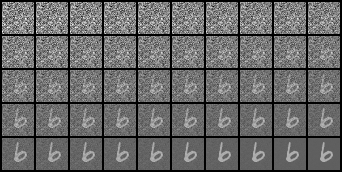

In [26]:
ema_model.eval()
out = sample_images(ema_model, 64, device)
out = (out+1)/2
img = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(out[0].cpu(), nrow=10, normalize=True))
img

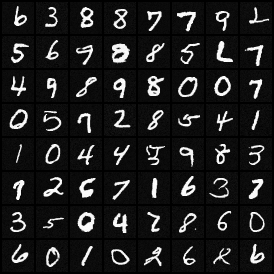

In [28]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(out[:, -1, ...].clamp(-1, 1).cpu(), nrow=8, normalize=True))

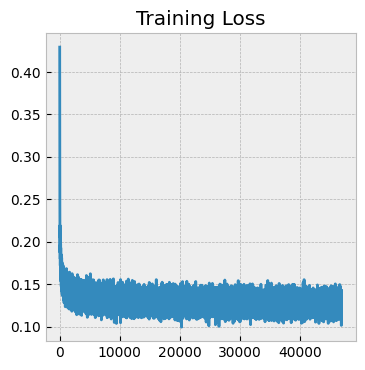

In [29]:
plt.figure(figsize=(4, 4))
plt.plot(train_loss[10:])
plt.title("Training Loss")
plt.show()

##  reverse flow is possible. 


we should be able to go back to noise and then flow back again to the same image.

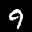

In [65]:
torchvision.transforms.ToPILImage()(imgs[10])

In [77]:
x1 = imgs[10].unsqueeze(0)
x1 = 2*x1-1
time_steps = torch.linspace(1, 0, 50)
x1.shape, time_steps.shape, x1.max(), x1.min()

(torch.Size([1, 1, 32, 32]), torch.Size([50]), tensor(1.), tensor(-1.))

In [78]:
outs = []
for i, t in tqdm(enumerate(time_steps)):
    if i == 0:
        xt = x1
    else:
        dt = time_steps[i-1] - time_steps[i]
        with torch.no_grad():
            out = model(xt.cuda(), t.repeat(1).cuda())["sample"].detach().cpu()
        xt = xt - dt*out
    outs.append(xt.squeeze(0))

outs = torch.stack(outs)
outs.shape

50it [00:00, 79.55it/s]


torch.Size([50, 1, 32, 32])

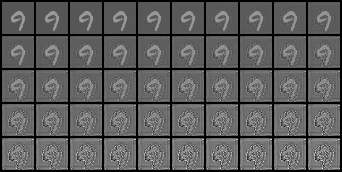

In [79]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(outs, nrow=10, normalize=True))

> Lets plot a histogram and see how distribution changed from image space to noise.

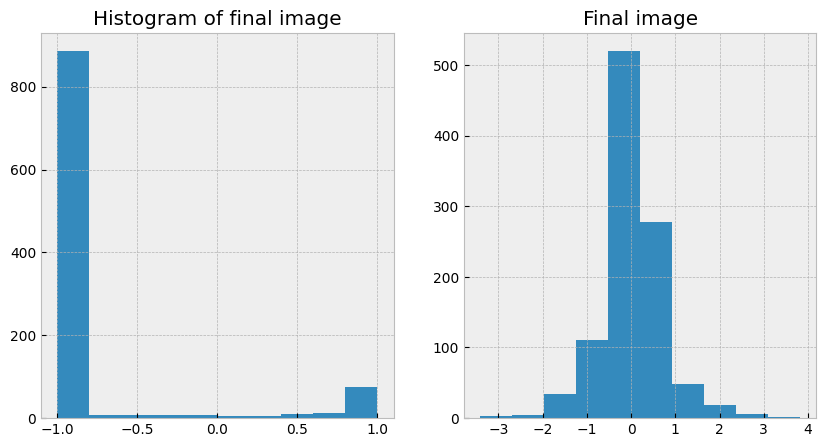

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(outs[0].flatten().cpu().numpy())
ax[0].set_title("Histogram of final image")
ax[1].hist(outs[-1].flatten().cpu().numpy())
ax[1].set_title("Final image")
plt.show()

> reconstruct from noise. 

In [88]:
noise = outs[-1].unsqueeze(0)
time_steps = torch.linspace(0, 1, 50)
outs_forward = []
for i, t in tqdm(enumerate(time_steps)):
    if i == 0:
        xt = noise
    else:
        dt = time_steps[i] - time_steps[i-1]
        with torch.no_grad():
            xt = xt + dt*model(xt.cuda(), t.repeat(1).cuda())["sample"].detach().cpu()
    outs_forward.append(xt.squeeze(0))
outs_forward = torch.stack(outs_forward)
outs_forward.shape

50it [00:00, 79.63it/s]


torch.Size([50, 1, 32, 32])

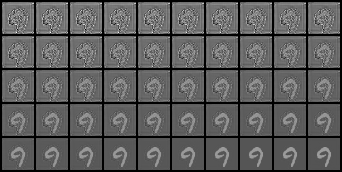

In [89]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(outs_forward, nrow=10, normalize=True))

## Now lets see if ODE solvers can be used to generate samples. 